In [1]:
from tokenizers.processors import BertProcessing
from tokenizers import ByteLevelBPETokenizer
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    BertTokenizer,
    BertModel,
    AutoModelWithLMHead,
    AutoTokenizer
)
from nltk.corpus import stopwords
import pytorch_lightning as pl
import textdistance as td
import numpy as np
import argparse
import torch
from torch import nn
import torch.nn.functional as F
import re
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yisiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset

In [2]:
import pandas as pd
# Load the dataset
df = pd.read_csv('pre_compute_label.csv', encoding='UTF-8')
df = df.drop(["empathy_score","fluency_score", "sentiment_score"], axis=1)

In [3]:
df.isnull().sum().sum()

46

In [5]:
df["Response"].fillna("a", inplace=True)

In [6]:
df1 = df.to_numpy()

In [3]:
df2 = df["Response"].dropna()
len(df2)

1492

In [4]:
df2.head()

0    Hello {Bob}, this is CreativeBot. How are you ...
1    Hi {}. I am a robot specialising in creativity...
2    Hi {}! How are you feeling today? I'm Creative...
3    Hello {}, I'm CreativeBot,my mission is to gui...
4    Hi {}, this is CreativeBot, I'm here to guide ...
Name: Response, dtype: object

In [5]:
df2 = df2.to_numpy()

## Empathy score

In [7]:
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))


class Mish(nn.Module):
    def forward(self, input):
        return mish(input)


class ClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)

        return self.classifier(hidden_states[0][:, 0, :])

In [8]:
# load roberta-model
with torch.no_grad():
    emp_model = ClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, 2)
    emp_model.load_state_dict(torch.load('NLP models/Empathy Classification/empathy_model/RoBERTa_empathy_2ft_2.pt', map_location=torch.device('cpu'))) #change path


c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\auto\modeling_auto.py:998: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [9]:
from re import S


def empathy_score(text):  # RoBERTa
    '''
    Computes a discrete numerical empathy score for an utterance (scale 0 to 1)
    '''

    # text = re.sub(r'[^\w\s]', '', text)
    # text = text.lower()
    t = ByteLevelBPETokenizer(
                "NLP models/Empathy Classification/tokenizer/vocab.json", #change path
                "NLP models/Empathy Classification/tokenizer/merges.txt"  #change path
            )
    t._tokenizer.post_processor = BertProcessing(
                ("</s>", t.token_to_id("</s>")),
                ("<s>", t.token_to_id("<s>")),
            )
    t.enable_truncation(512)
    t.enable_padding(pad_id=t.token_to_id("<pad>"))
    tokenizer = t
    encoded = tokenizer.encode(text)
    sequence_padded = torch.tensor(encoded.ids).unsqueeze(0)
    attention_mask_padded = torch.tensor(encoded.attention_mask).unsqueeze(0)
    with torch.no_grad():
        output = emp_model((sequence_padded, attention_mask_padded))
    top_p, top_class = output.topk(1, dim=1)
    label = int(top_class[0][0])
    # normalise between 0 and 1 dividing by the highest possible value:
    return label

In [10]:
emp_list = []
for i in df1:
    empathy = empathy_score(i[0])
    emp_list.append(empathy)
print(len(emp_list))
print(len(df1))

1538
1538


In [12]:
emp_score = pd.DataFrame(emp_list,columns=["empathy_score"])
emp_score.head()

,empathy_score
0,0
1,1
2,1
3,1
4,1


In [13]:
emp_score.groupby("empathy_score").size()

empathy_score
0    651
1    887
dtype: int64

In [14]:
emp_score.to_csv("empathy_score.csv")

## Fluency score

In [6]:
# Load pre-trained GPT2 language model weights
with torch.no_grad():
    gptmodel = GPT2LMHeadModel.from_pretrained('gpt2')
    gptmodel.eval()

# Load pre-trained GPT2 tokenizer
gpttokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# simple tokenizer + stemmer
regextokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.PorterStemmer()


In [7]:
def perplexity(sentence):
    '''
    Computes the PPL of an utterance using GPT2 LM
    '''
    tokenize_input = gpttokenizer.encode(sentence)
    tensor_input = torch.tensor([tokenize_input])
    with torch.no_grad():
        loss = gptmodel(tensor_input, labels=tensor_input)[0]
    return np.exp(loss.detach().numpy())

In [8]:
def repetition_penalty(sentence):
    '''
    Adds a penalty for each repeated (stemmed) token in
    an utterance. Returns the total penalty of the sentence
    '''
    word_list = regextokenizer.tokenize(sentence.lower())
    filtered_words = [
        word for word in word_list if word not in stopwords.words('english')]
    stem_list = [stemmer.stem(word) for word in filtered_words]
    penalty = 0
    visited = []
    for w in stem_list:
        if w not in visited:
            visited.append(w)
        else:
            penalty += 0.001
    return penalty

In [9]:
def fluency_score(sentence):
    '''
    Computes the fluency score of an utterance, given by the
    inverse of the perplexity minus a penalty for repeated tokens
    '''
    ppl = perplexity(sentence)
    penalty = repetition_penalty(sentence)
    score = (1 / ppl) - penalty
    # normalise by the highest possible fluency computed on the corpus:
    normalised_score = score / 0.155
    if normalised_score < 0:
        normalised_score = 0
    return round(normalised_score, 2)

In [ ]:
fl_list = []
for i in df1:
    fl_score = fluency_score(i[0])
    fl_list.append(fl_score)
print(len(fl_list))
print(len(df1))

In [24]:
fl_scores = pd.DataFrame(fl_list,columns=["fluency_score"])
fl_scores.head()

,fluency_score
0,0.02
1,0.05
2,0.11
3,0.09
4,0.04


In [25]:
fl_scores.to_csv("fluency_score.csv")

In [14]:
fl_list = []
for i in df2:
    fl_score = fluency_score(i)
    fl_list.append(fl_score)
print(len(fl_list))
print(len(df2))

1492
1492


In [32]:
import math
fl_list_mod = []
for i in fl_list:
    n_score = (math.log(i) + 5)/5
    fl_list_mod.append(n_score)

Text(0, 0.5, 'Sentence count')

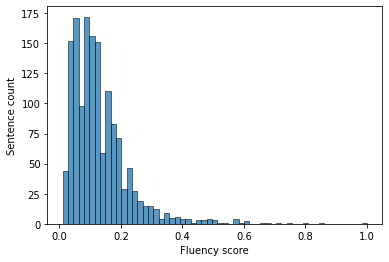

In [21]:
import seaborn as sns
sp1 = sns.histplot(fl_list)
sp1.set_xlabel('Fluency score')
sp1.set_ylabel('Sentence count')

Text(0, 0.5, 'Sentence count')

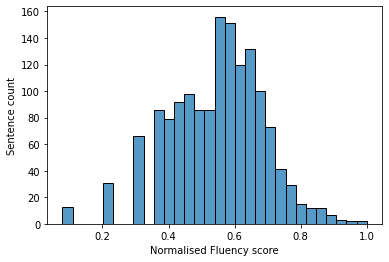

In [58]:
sp2 = sns.histplot(fl_list_mod)
sp2.set_xlabel('Normalised Fluency score')
sp2.set_ylabel('Sentence count')

In [29]:
math.log(1/0.1)

2.302585092994046

## Sentiment Score

In [60]:
!pip install vaderSentiment

     ------------------------------------ 126.0/126.0 KB 185.1 kB/s eta 0:00:00


You should consider upgrading via the 'c:\users\yisiang\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [17]:
def sentiment_score(sentence):
    """
    Compute the sentiment score of the sentence. Scale (-1, 1).
    and also normalized to scale of (0,1) by adding 1 and divide by 2. max(0.9836), min(-0.613)
    """
    analyzer = SentimentIntensityAnalyzer()
    sent_score = analyzer.polarity_scores(sentence)
    sent_score =  (sent_score["compound"] + 0.613)/ (0.9836+0.613)
    return sent_score

In [28]:
sent_list = []
for i in df1:
    sent_score = sentiment_score(i[0])
    sent_list.append(sent_score)
print(len(sent_list))
print(len(df1))

1538
1538


In [30]:
sent_scores = pd.DataFrame(sent_list,columns=["sentiment_score"])
sent_scores.head()

,sentiment_score
0,0.464111
1,0.803896
2,0.941876
3,0.896029
4,0.659777


In [31]:
sent_scores.to_csv("sentiment_score_1.csv")

In [18]:
sent_list = []
for i in df2:
    sent_score = sentiment_score(i)
    sent_list.append(sent_score)
print(len(sent_list))
print(len(df2))

1492
1492


Text(0, 0.5, 'Sentence count')

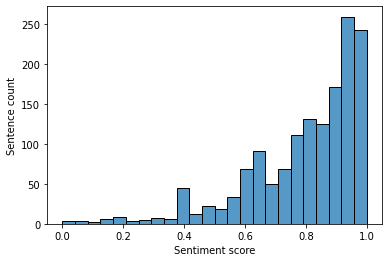

In [19]:
import seaborn as sns
sp1 = sns.histplot(sent_list)
sp1.set_xlabel('Sentiment score')
sp1.set_ylabel('Sentence count')

In [50]:
import math
sent_list_mod = []
for i in sent_list:
    s_score = (math.log(1- i+0.00001) +6)/6
    sent_list_mod.append(s_score)

(0.0, 1.0)

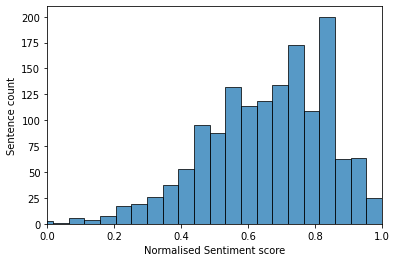

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sp2 = sns.histplot(sent_list_mod, ax=ax)
sp2.set_xlabel('Normalised Sentiment score')
sp2.set_ylabel('Sentence count')
ax.set_xlim(0,1)
